In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Colab")\
        .getOrCreate()

In [ ]:
#  .master("local")\.config('spark.ui.port', '4050') \ (Configuring the Spark UI port in PySpark allows you to specify which port the Spark User Interface (UI) will listen on.
#The Spark UI is a web-based dashboard that provides valuable information and insights into the status and progress of your Spark application. ) http://localhost:4050

In [ ]:
spark

In [ ]:

df2020  = spark.read.csv("/content/drive/MyDrive/Colab Dataset/CEEW - Smart meter data Bareilly 2020.csv", header=True, inferSchema=True)
# df2021 = spark.read.csv("/content/CEEW - Smart meter data Bareilly 2021.csv", header=True, inferSchema=True)

In [ ]:
df2020.show()

+-------------------+-----+--------------------+-------------------+-----------+-----+
|        x_Timestamp|t_kWh|z_Avg Voltage (Volt)|z_Avg Current (Amp)|y_Freq (Hz)|meter|
+-------------------+-----+--------------------+-------------------+-----------+-----+
|2020-01-01 00:00:00|0.002|              251.26|               0.15|      49.97| BR02|
|2020-01-01 00:03:00|0.001|              251.23|               0.15|      49.94| BR02|
|2020-01-01 00:06:00|0.001|              251.55|               0.14|      49.94| BR02|
|2020-01-01 00:09:00|0.001|              251.97|               0.14|      50.09| BR02|
|2020-01-01 00:12:00|0.002|              252.03|               0.14|      50.08| BR02|
|2020-01-01 00:15:00|0.001|              251.78|               0.14|       50.0| BR02|
|2020-01-01 00:18:00|0.001|              251.75|               0.13|      49.97| BR02|
|2020-01-01 00:21:00|0.001|              251.95|               0.14|       50.0| BR02|
|2020-01-01 00:24:00|0.002|              25

In [ ]:
df2020.describe().show()

+-------+--------------------+--------------------+-------------------+------------------+-------+
|summary|               t_kWh|z_Avg Voltage (Volt)|z_Avg Current (Amp)|       y_Freq (Hz)|  meter|
+-------+--------------------+--------------------+-------------------+------------------+-------+
|  count|             6627360|             6627360|            6627360|           6627360|6627360|
|   mean| 0.01672798595517289|   226.3324408889855| 1.5699208251845795|46.459638817051044|   NULL|
| stddev|0.024216953003742207|   64.33306545698716| 2.1363581436250936| 12.83021750341025|   NULL|
|    min|                 0.0|                 0.0|                0.0|               0.0|   BR02|
|    max|                 0.3|              654.67|              57.04|            208.33|   BR52|
+-------+--------------------+--------------------+-------------------+------------------+-------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag  # Import the lag function


In [ ]:

# Convert the 'x_Timestamp' column to a timestamp type
df2020 = df2020.withColumn('x_Timestamp', col('x_Timestamp').cast('timestamp'))

# Extract date and time-related features
df2020 = df2020.withColumn('Year', F.year('x_Timestamp'))
df2020 = df2020.withColumn('Month', F.month('x_Timestamp'))
df2020 = df2020.withColumn('Day', F.dayofmonth('x_Timestamp'))
df2020 = df2020.withColumn('Hour', F.hour('x_Timestamp'))
df2020 = df2020.withColumn('Minute', F.minute('x_Timestamp'))
df2020 = df2020.withColumn('Second', F.second('x_Timestamp'))
df2020 = df2020.withColumn('DayOfWeek', F.dayofweek('x_Timestamp'))
df2020 = df2020.withColumn("Supply", (col("z_Avg Voltage (Volt)") * col("z_Avg Current (Amp)"))/(1000))

df2020 = df2020.withColumn("demand", (col("t_kWh")*60/3 ))
# Define a window specification for ordering the data by timestamp
window_spec = Window.partitionBy("meter").orderBy("x_Timestamp")

# Add a lag column to calculate the difference in t_kWh between consecutive timestamps
df2020 = df2020.withColumn("t_kWh_lag", F.lag("t_kWh").over(window_spec))

# Calculate the difference in t_kWh between consecutive timestamps
df2020 = df2020.withColumn("t_kWh_diff", col("t_kWh") - col("t_kWh_lag"))

# Show the DataFrame with the added date, time, and difference columns
df2020.show()

+-------------------+-----+--------------------+-------------------+-----------+-----+----+-----+---+----+------+------+---------+-------------------+-------------------+---------+--------------------+
|        x_Timestamp|t_kWh|z_Avg Voltage (Volt)|z_Avg Current (Amp)|y_Freq (Hz)|meter|Year|Month|Day|Hour|Minute|Second|DayOfWeek|             Supply|             demand|t_kWh_lag|          t_kWh_diff|
+-------------------+-----+--------------------+-------------------+-----------+-----+----+-----+---+----+------+------+---------+-------------------+-------------------+---------+--------------------+
|2020-01-01 00:00:00|0.006|              249.54|               0.76|      49.98| BR04|2020|    1|  1|   0|     0|     0|        4|          0.1896504|               0.12|     NULL|                NULL|
|2020-01-01 00:03:00|0.007|              249.15|               0.75|      49.95| BR04|2020|    1|  1|   0|     3|     0|        4|0.18686250000000001|0.13999999999999999|    0.006|            

In [ ]:
import pandas as pd

7 represents Sunday while 1 represents Monday.

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

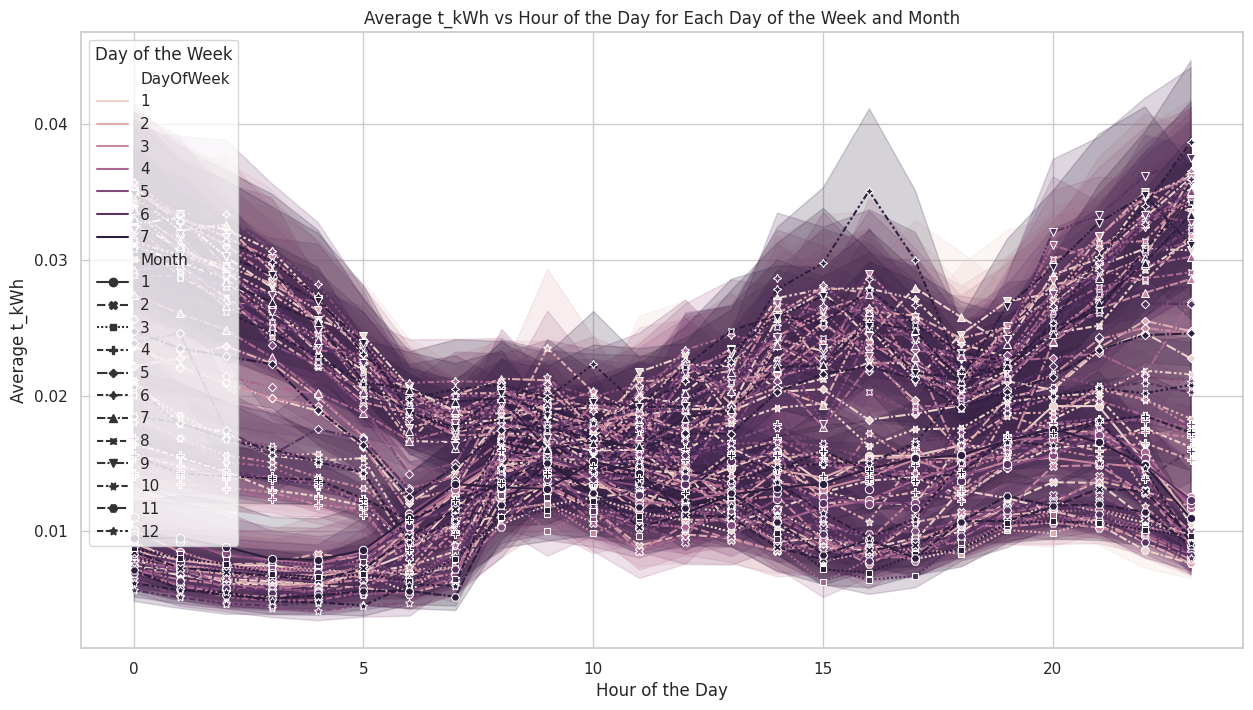

In [ ]:
# Define a window specification for ordering the data by timestamp
window_spec = Window.partitionBy("meter", "Year", "Month", "Day", "DayOfWeek").orderBy("Hour")

# Calculate the average t_kWh for each combination of day of the week, month, and hour of the day
df_agg = df2020.groupBy("meter", "Year", "Month", "Day", "DayOfWeek", "Hour").agg(F.avg("t_kWh").alias("Avg_t_kWh"))

# Convert to Pandas for plotting
df_pd = df_agg.toPandas()

# Set seaborn style
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(15, 8))
sns.lineplot(x='Hour', y='Avg_t_kWh', hue='DayOfWeek', data=df_pd, style='Month', markers=True)
plt.title('Average t_kWh vs Hour of the Day for Each Day of the Week and Month')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t_kWh')
plt.legend(title='Day of the Week')
plt.show()

In [ ]:

window_spec = Window.partitionBy("meter", "Year", "Month", "Day", "DayOfWeek").orderBy("Hour")

# Calculate the average t_kWh for each combination of day of the week, month, and hour of the day
df_agg = df2020.groupBy("meter", "Year", "Month", "Day", "DayOfWeek", "Hour").agg(F.avg("t_kWh").alias("Avg_t_kWh"))

# Convert to Pandas for plotting
df_pd = df_agg.toPandas()

# Set seaborn style
sns.set(style="whitegrid")



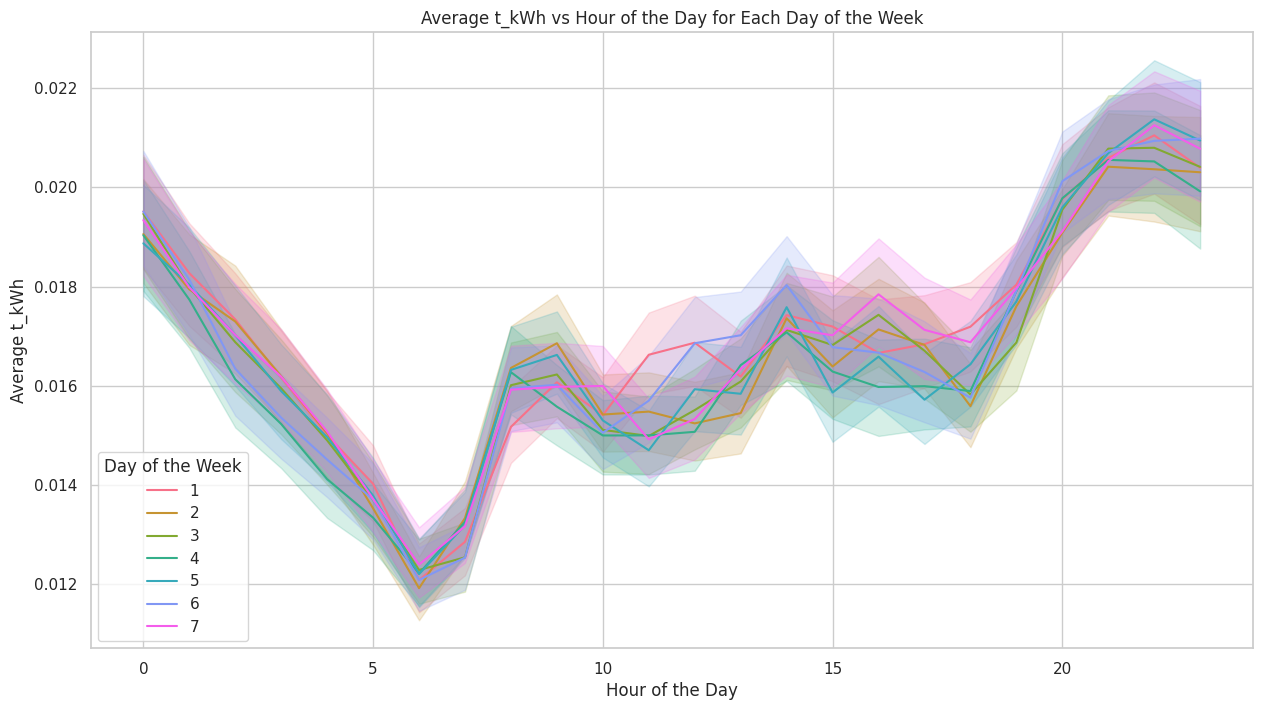

In [ ]:
# Get the number of unique months in the dataset
num_week = len(df_pd['DayOfWeek'].unique())
sns.set(style="whitegrid")
# Plotting for Day of the Week
plt.figure(figsize=(15, 8))
sns.lineplot(x='Hour', y='Avg_t_kWh', hue='DayOfWeek', data=df_pd, markers=True, palette=sns.color_palette("husl", num_week))
plt.title('Average t_kWh vs Hour of the Day for Each Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t_kWh')
plt.legend(title='Day of the Week')
plt.show()



<ipython-input-23-0d276d7eb359>:4: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='Hour', y='Avg_t_kWh', hue='DayOfWeek', data=df_pd, markers=True, palette=sns.color_palette("husl"))


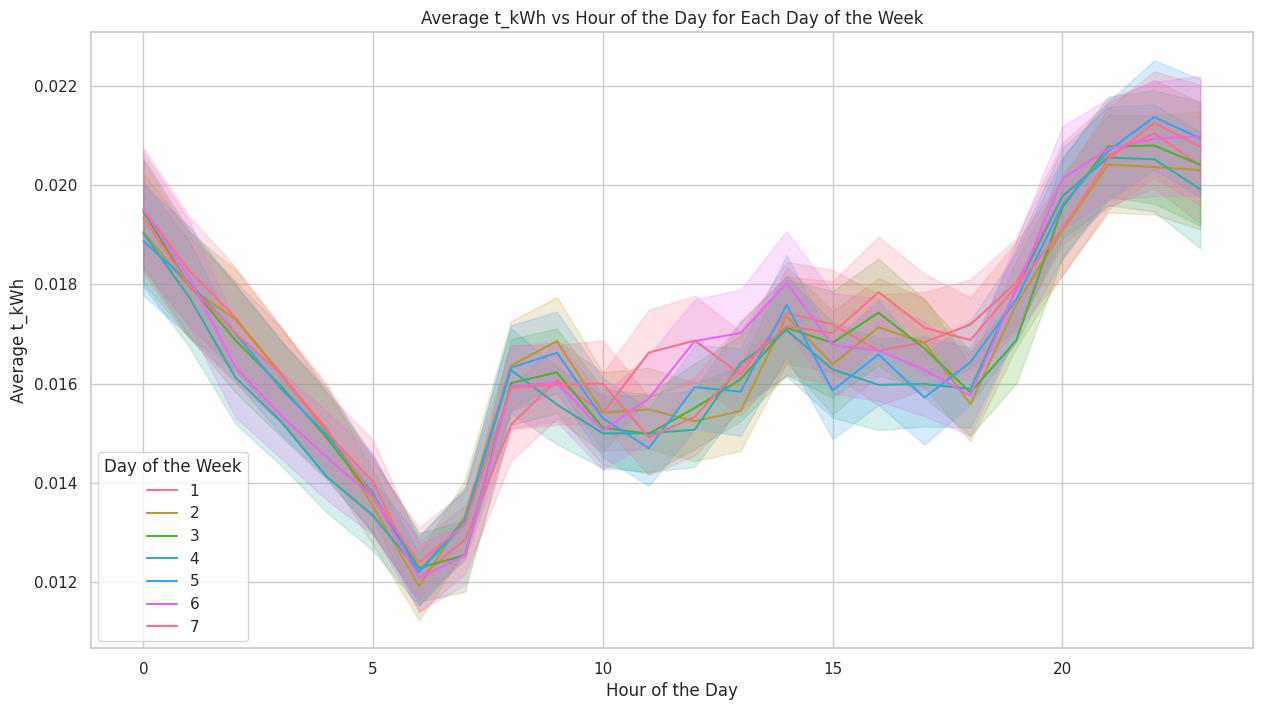

In [ ]:
sns.set(style="whitegrid")
# Plotting for Day of the Week
plt.figure(figsize=(15, 8))
sns.lineplot(x='Hour', y='Avg_t_kWh', hue='DayOfWeek', data=df_pd, markers=True, palette=sns.color_palette("husl"))
plt.title('Average t_kWh vs Hour of the Day for Each Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t_kWh')
plt.legend(title='Day of the Week')
plt.show()


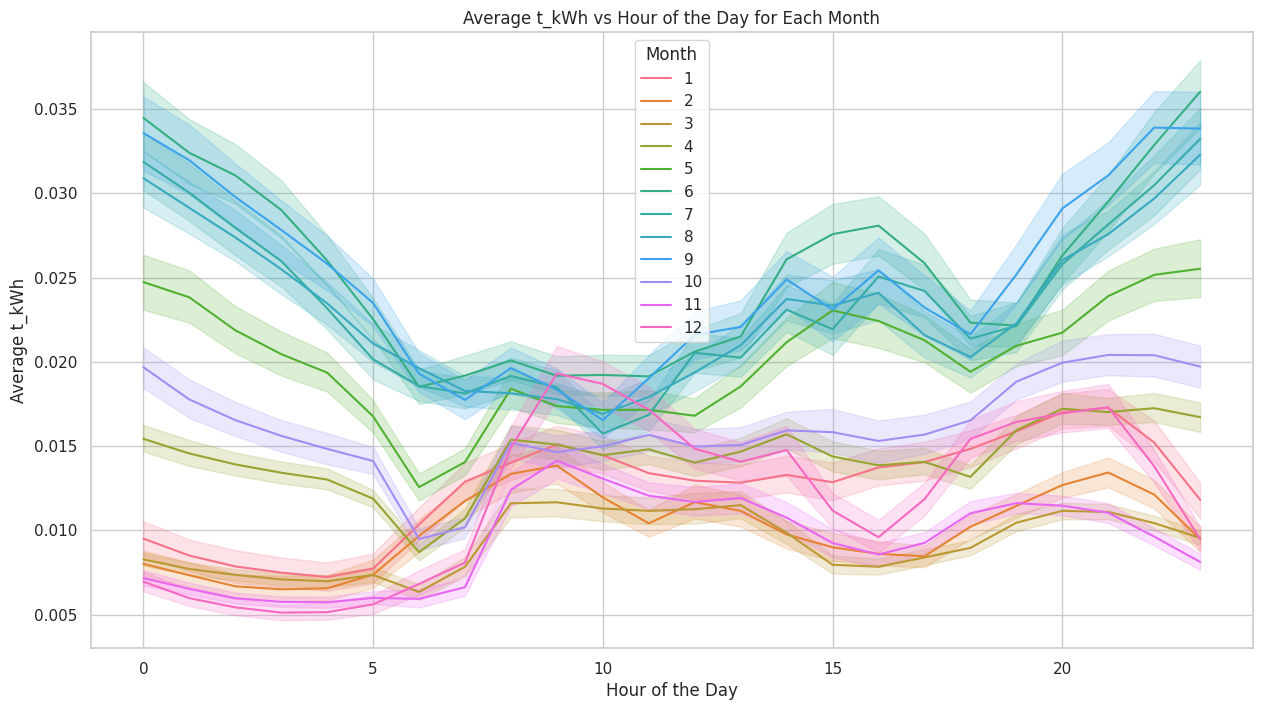

In [ ]:
# Get the number of unique months in the dataset
num_months = len(df_pd['Month'].unique())

# Set seaborn style
sns.set(style="whitegrid")

# Plotting for Month with rainbow color
plt.figure(figsize=(15, 8))
sns.lineplot(x='Hour', y='Avg_t_kWh', hue='Month', data=df_pd, markers=True, palette=sns.color_palette("husl", num_months))
plt.title('Average t_kWh vs Hour of the Day for Each Month')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t_kWh')
plt.legend(title='Month')
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation


In [ ]:
# Select relevant columns for analysis
selected_columns = [
    "t_kWh",
    "z_Avg Voltage (Volt)",
    "z_Avg Current (Amp)",
    "y_Freq (Hz)",
    "Year",
    "Month",
    "Day",
    "Hour",
    "Minute",
    "Second",
    "t_kWh_lag",
    "t_kWh_diff",
    "DayOfWeek"
]

# Select the relevant columns from df20202
df_selected = df2020.select(selected_columns)

# Create a feature vector from selected columns
assembler = VectorAssembler(inputCols=[col for col in selected_columns[1:]], outputCol="features")
df_assembled = assembler.transform(df_selected)


In [ ]:

correlation_matrix = df2020_pd.corr()


In [ ]:
import matplotlib.pyplot as plt


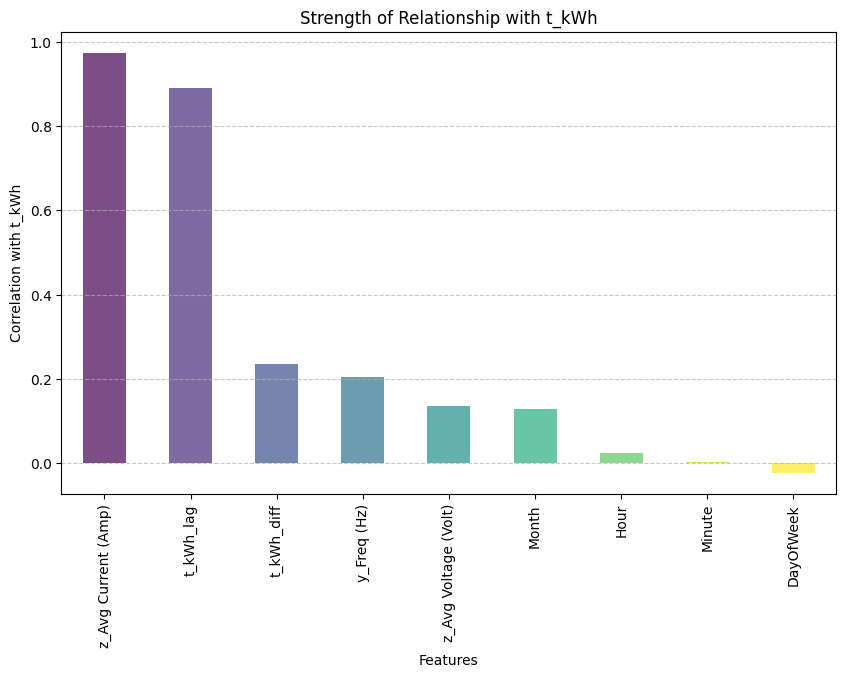

In [ ]:

# Extract the correlation values for t_kWh
correlation_with_tkwh = correlation_matrix.loc['t_kWh'].drop(['t_kWh', 'Year', 'Second', 'Day'])

# Sort the correlation values in decreasing order
correlation_with_tkwh_sorted = correlation_with_tkwh.sort_values(ascending=False)

# Plot the bar chart with colorful bars
colors = plt.cm.viridis(np.linspace(0, 1, len(correlation_with_tkwh_sorted)))
plt.figure(figsize=(10, 6))
correlation_with_tkwh_sorted.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Strength of Relationship with t_kWh')
plt.xlabel('Features')
plt.ylabel('Correlation with t_kWh')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline

In [ ]:

# Define categorical columns for one-hot encoding
categorical_columns = ["DayOfWeek", "Month",  "Hour"]

# Create a list of stages for the pipeline
stages = []

# Scale continuous features
continuous_columns = [ "t_kWh_lag",
    "t_kWh_diff"]
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
stages += [scaler]

# One-hot encode categorical features
for col in categorical_columns:
    encoder = OneHotEncoder(inputCols=[col], outputCols=[col + "_encoded"])
    stages += [encoder]

# Assemble all features (scaled continuous and one-hot encoded categorical)
assembler_all = VectorAssembler(inputCols=["scaled_features"] + [col + "_encoded" for col in categorical_columns],
                                 outputCol="final_features")
stages += [assembler_all]

# Create a pipeline with all the stages
preprocessing_pipeline = Pipeline(stages=stages)

# Fit and transform the data using the pipeline
preprocessed_data = preprocessing_pipeline.fit(df_assembled).transform(df_assembled)

# Select the relevant columns for model training
selected_data = preprocessed_data.select("final_features", "t_kWh")

# Show the preprocessed data
selected_data.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|final_features                                                                                                                                              |t_kWh|
+------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(25,[0,1,2,3,4,5,10,14],[0.3243418555362413,-0.8872143118652637,0.22051035636073893,-1.6607174772685958,-0.013207925529547512,-1.2543982520519943,1.0,1.0]) |0.002|
|(25,[0,1,2,3,4,5,10,14],[0.32377687947213096,-0.8872143118652637,0.21769607134753022,-1.6607174772685958,-0.013207925529547512,-1.2543982520519943,1.0,1.0])|0.001|
|(25,[0,1,2,3,4,5,10,14],[0.3298032908226416,-0.894948949073145,0.21769607134753022,-1.6607174772685958,-0.013207925529547512,-1.2543982520519943,1.0,1.0])  |0.001|
|(25,[0,1,

In [ ]:
from pyspark.ml.classification import LinearSVC, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:

# Define feature and target columns
feature_column = "final_features"
target_column = "t_kWh"

# Split the data into training and testing sets
train_data, test_data = selected_data.randomSplit([0.8, 0.2], seed=123)


In [ ]:
train_data.describe().show()

+-------+--------------------+
|summary|               t_kWh|
+-------+--------------------+
|  count|              187888|
|   mean|0.013074608277266626|
| stddev|0.014225752453808676|
|    min|                 0.0|
|    max|               0.172|
+-------+--------------------+



In [ ]:
test_data.describe().show()


+-------+--------------------+
|summary|               t_kWh|
+-------+--------------------+
|  count|               46885|
|   mean|0.013064327610108766|
| stddev|0.014154981194566988|
|    min|                 0.0|
|    max|               0.172|
+-------+--------------------+



In [ ]:
selected_data.describe().show()

+-------+--------------------+
|summary|               t_kWh|
+-------+--------------------+
|  count|              234773|
|   mean|0.013072555191602903|
| stddev|0.014211617853544014|
|    min|                 0.0|
|    max|               0.172|
+-------+--------------------+



In [ ]:

# GBT Regressor
gbt_regressor = GBTRegressor(featuresCol=feature_column, labelCol=target_column, seed=123)

# Linear SVR

# Evaluation metric
evaluator = RegressionEvaluator(labelCol=target_column, metricName="rmse")

# Create a pipeline for each model
gbt_pipeline = Pipeline(stages=[gbt_regressor])
# svm_pipeline = Pipeline(stages=[svm_regressor])

# Set up the parameter grid for cross-validation
param_grid_gbt = ParamGridBuilder().addGrid(gbt_regressor.maxDepth, [5, 10]).build()
# param_grid_svm = ParamGridBuilder().addGrid(svm_regressor.regParam, [0.1, 0.01]).build()

# Cross-Validation
gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                              estimatorParamMaps=param_grid_gbt,
                              evaluator=evaluator,
                              numFolds=5)


# Train the models
gbt_model = gbt_crossval.fit(train_data)
# svm_model = svm_crossval.fit(train_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)
# svm_predictions = svm_model.transform(test_data)

# Evaluate the models
gbt_rmse = evaluator.evaluate(gbt_predictions)
# svm_rmse = evaluator.evaluate(svm_predictions)

# Print the RMSE for each model
print("GBT RMSE:", gbt_rmse)
# print("SVM RMSE:", svm_rmse)

GBT RMSE: 0.002696078941981846


In [ ]:
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor


In [ ]:

# Random Forest Regressor
rf_regressor = RandomForestRegressor(featuresCol=feature_column, labelCol=target_column, seed=123)

# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(featuresCol=feature_column, labelCol=target_column, seed=123)

# Evaluation metric
evaluator = RegressionEvaluator(labelCol=target_column, metricName="rmse")

# Create pipelines for each model
rf_pipeline = Pipeline(stages=[rf_regressor])
dt_pipeline = Pipeline(stages=[dt_regressor])

# Set up the parameter grid for cross-validation
param_grid_rf = ParamGridBuilder().addGrid(rf_regressor.maxDepth, [5, 10]).addGrid(rf_regressor.numTrees, [10, 20]).build()
param_grid_dt = ParamGridBuilder().addGrid(dt_regressor.maxDepth, [5, 10]).build()

# Cross-Validation
rf_crossval = CrossValidator(estimator=rf_pipeline,
                             estimatorParamMaps=param_grid_rf,
                             evaluator=evaluator,
                             numFolds=5)

dt_crossval = CrossValidator(estimator=dt_pipeline,
                             estimatorParamMaps=param_grid_dt,
                             evaluator=evaluator,
                             numFolds=5)

# Train the models
rf_model = rf_crossval.fit(train_data)
dt_model = dt_crossval.fit(train_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate the models
rf_rmse = evaluator.evaluate(rf_predictions)
dt_rmse = evaluator.evaluate(dt_predictions)

# Print the RMSE for each model
print("Random Forest RMSE:", rf_rmse)
print("Decision Tree RMSE:", dt_rmse)

Random Forest RMSE: 0.0031064942999272692
Decision Tree RMSE: 0.002875342442711527


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming you have the predictions for each model (e.g., gbt_predictions, svm_predictions, rf_predictions, dt_predictions)

# Evaluate function for R^2
def calculate_r2(predictions, target_column='t_kWh'):
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol='prediction', metricName='r2')
    return evaluator.evaluate(predictions)

# Evaluate function for MAE
def calculate_mae(predictions, target_column='t_kWh'):
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol='prediction', metricName='mae')
    return evaluator.evaluate(predictions)


# Calculate metrics for each model
gbt_r2 = calculate_r2(gbt_predictions)
rf_r2 = calculate_r2(rf_predictions)
dt_r2 = calculate_r2(dt_predictions)

gbt_mae = calculate_mae(gbt_predictions)
rf_mae = calculate_mae(rf_predictions)
dt_mae = calculate_mae(dt_predictions)




In [ ]:
# Evaluate function for MAPE
def calculate_mape(predictions, target_column='t_kWh'):
    predictions = predictions.withColumn('mape', F.abs((F.col(target_column) - F.col('prediction')) / F.col(target_column)) * 100)
    mape = predictions.agg(F.avg('mape')).collect()[0][0]
    return mape


gbt_mape = calculate_mape(gbt_predictions)
rf_mape = calculate_mape(rf_predictions)
dt_mape = calculate_mape(dt_predictions)


In [ ]:
# Print the metrics for each model
print("GBT: R^2 =", gbt_r2, ", MAE =", gbt_mae, ", MAPE =", gbt_mape)
print("Random Forest: R^2 =", rf_r2, ", MAE =", rf_mae, ", MAPE =", rf_mape)
print("Decision Tree: R^2 =", dt_r2, ", MAE =", dt_mae, ", MAPE =", dt_mape)

GBT: R^2 = 0.9637209523289185 , MAE = 0.0012924458056159805 , MAPE = 15.762176192580052
Random Forest: R^2 = 0.9518349748097784 , MAE = 0.0017334644238356245 , MAPE = 23.218273314610055
Decision Tree: R^2 = 0.9587361430154188 , MAE = 0.001426540065337362 , MAPE = 16.702031813424455


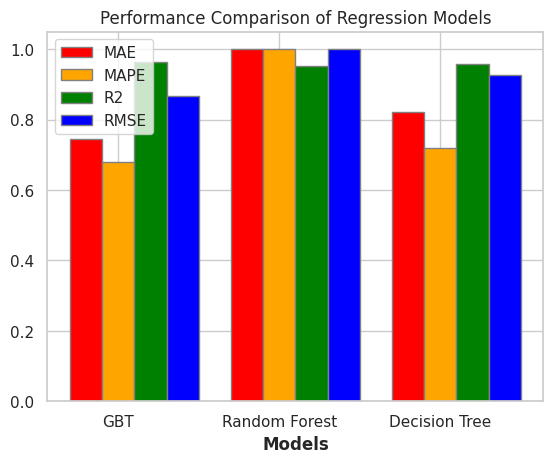

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the calculated metrics for each model
models = ['GBT', 'Random Forest', 'Decision Tree']
mae_values = [gbt_mae, rf_mae, dt_mae]
mape_values = [gbt_mape, rf_mape, dt_mape]
r2_values = [gbt_r2, rf_r2, dt_r2]
rmse_values = [gbt_rmse, rf_rmse, dt_rmse]

# Normalize the metrics for better visualization
mae_values = np.array(mae_values) / np.max(mae_values)
mape_values = np.array(mape_values) / np.max(mape_values)
r2_values = np.array(r2_values)
rmse_values = np.array(rmse_values) / np.max(rmse_values)


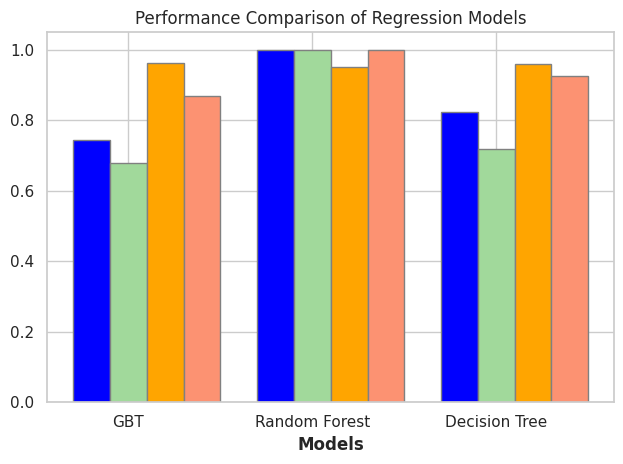

In [ ]:

# Create a colorful bar graph
barWidth = 0.2
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.bar(r1, mae_values, color='blue', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r2, mape_values, color='#a1d99b', width=barWidth, edgecolor='grey', label='MAPE')
plt.bar(r3, r2_values, color='orange', width=barWidth, edgecolor='grey', label='R2')
plt.bar(r4, rmse_values, color='#fc9272', width=barWidth, edgecolor='grey', label='RMSE')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.title('Performance Comparison of Regression Models')
# plt.legend()
plt.tight_layout()
plt.show()


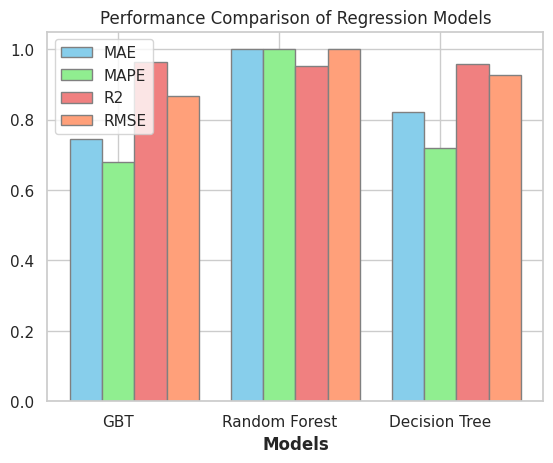

In [ ]:

# Create a colorful bar graph
barWidth = 0.2
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, mae_values, color='skyblue', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r2, mape_values, color='lightgreen', width=barWidth, edgecolor='grey', label='MAPE')
plt.bar(r3, r2_values, color='lightcoral', width=barWidth, edgecolor='grey', label='R2')
plt.bar(r4, rmse_values, color='lightsalmon', width=barWidth, edgecolor='grey', label='RMSE')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.title('Performance Comparison of Regression Models')
plt.legend()
plt.show()

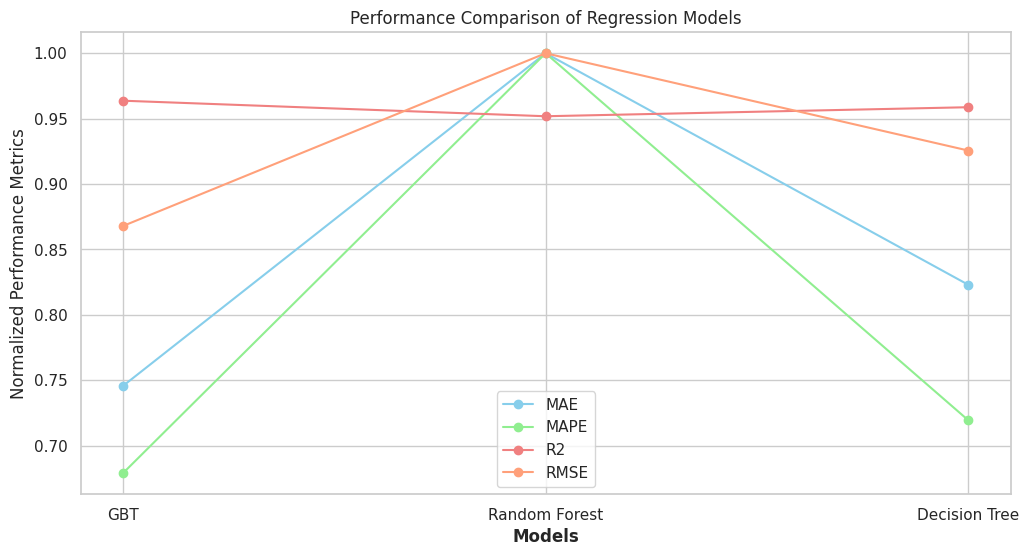

In [ ]:

# Create a line plot
plt.figure(figsize=(12, 6))

plt.plot(models, mae_values, marker='o', label='MAE', color='skyblue')
plt.plot(models, mape_values, marker='o', label='MAPE', color='lightgreen')
plt.plot(models, r2_values, marker='o', label='R2', color='lightcoral')
plt.plot(models, rmse_values, marker='o', label='RMSE', color='lightsalmon')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Normalized Performance Metrics')
plt.title('Performance Comparison of Regression Models')
plt.legend()
plt.grid(True)
plt.show()